# Metabolite related DEGs Analysis

This notebook implements an integrated workflow to investigate how specific metabolites modulate *Citrobacter rodentium* gene expression through defined metabolic pathways.  
Starting from RNA-seq–derived DEGs, the analysis:
1. maps KEGG pathway proteins to the *C. rodentium* proteome using BLASTp, 
2. intersects pathway genes with statistically significant DEGs, 
3. prioritizes the best matches per protein. 

The final output consists of pathway-specific DEG tables and heatmaps summarizing log2 fold-change patterns, enabling functional interpretation of how metabolite availability (e.g. fructose or malate) impacts bacterial metabolism and virulence-associated processes.

In [ ]:
import time, requests, re, os
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import pandas as pd

## FUNCTIONS

### 1. Download das proteínas dos genes da via KEGG API

In [ ]:
def DownloadPathProteins(kegg_pathway, out_dir):
    """
    Download protein amino acid sequences (aaseq) from KEGG for a given pathway.

    PARAMETERS:
    kegg_pathway : str -->  KEGG pathway identifier (e.g., 'ROD00051').
    out_dir : str --> Output directory where the FASTA file will be saved.

    RETURNS:
    str --> Path to the generated FASTA file containing protein sequences related to the indicated KEGG pathway.
    """

    # Format pathway identifier for KEGG REST API
    pathway = f"path:{kegg_pathway}"

    # KEGG endpoint to retrieve genes linked to the pathway (cro:ROD_XXXX)
    link_url = f"https://rest.kegg.jp/link/cro/{pathway}"

    # Output FASTA file
    out_fasta = os.path.join(out_dir, f"{kegg_pathway}_proteins.faa")

    # 1) Retrieve KEGG gene IDs associated with the pathway
    resp = requests.get(link_url, timeout=30)
    resp.raise_for_status()
    gene_ids = [
        line.split("\t")[1].strip()
        for line in resp.text.strip().splitlines()
        if line.strip()
    ]

    # 2) Download protein amino acid sequences (aaseq) for each gene
    with open(out_fasta, "w") as out:
        for g in gene_ids:
            url = f"https://rest.kegg.jp/get/{g}/aaseq"
            r = requests.get(url, timeout=30)

            # Write FASTA entry only if a valid sequence is returned
            if r.status_code == 200 and r.text.startswith(">"):
                out.write(r.text if r.text.endswith("\n") else r.text + "\n")
            else:
                print(f"[warn] No protein sequence available for {g}")

            # Small delay to respect KEGG API rate limits
            time.sleep(0.2)

    print(
        f"Protein sequence download completed: {out_fasta} "
        f"({len(gene_ids)} pathway genes queried)."
    )
    return out_fasta


### 2. BLASTp C. rodentium X Path proteins

In [ ]:

def RunBlastp(work_dir, proteome_fasta, pathway_fasta, db_prefix, output_tsv):
    """
    Run a local BLASTp search between the *C. rodentium* proteome and proteins
    associated with a specific KEGG metabolic pathway.

    PARAMETERS:
    work_dir : str --> Working directory to create and store the BLAST database.
    proteome_fasta : str --> FASTA file of the complete *C. rodentium* proteome (query).
    pathway_fasta : str --> FASTA file containing KEGG pathway protein sequences (database).
    db_prefix : str --> Prefix name for the BLAST database.
    output_tsv : str --> Path to the output TSV file with BLASTp results.

    RETURNS:
    None --> Results are written to the specified output TSV file.
    """

    # Create a directory to store the BLAST database
    db_dir = os.path.join(work_dir, f"blast_db_{db_prefix}")
    os.makedirs(db_dir, exist_ok=True)

    # Full path prefix for the BLAST database files
    db_prefix_path = os.path.join(db_dir, db_prefix)

    # Build a local BLAST protein database from the pathway FASTA
    subprocess.run(
        [   "makeblastdb",
            "-in", pathway_fasta,
            "-dbtype", "prot",
            "-out", db_prefix_path        ],
        check=True)

    # Run BLASTp: query = full proteome, database = pathway proteins, exporting results to TSV
    subprocess.run(
        [   "blastp",
            "-query", proteome_fasta,
            "-db", db_prefix_path,
            "-evalue", "1e-5",
            "-outfmt", "6 qseqid sseqid pident length evalue bitscore stitle",
            "-out", output_tsv       ],
        check=True)



### 3. DEGs FILTERING

In [ ]:
## IMPORT WP IDs FILE
def Import_WP_IDs(input_file):
    """
    Import and standardize the mapping between locus tags and NCBI WP protein IDs.

    PARAMETERS:
    input_file : str --> Path to CSV file containing 'Locus Tag' and 'WP ID' columns.

    RETURNS:
    pd.DataFrame --> DataFrame with standardized gene identifiers ('Gene') and corresponding WP IDs.
    """
    wp_ids = pd.read_csv(input_file)
    wp_ids["Locus Tag"] = wp_ids["Locus Tag"].str.replace("TA05_", "", regex=False)
    wp_ids = wp_ids.rename(columns={"Locus Tag": "Gene"})

    return wp_ids


## IMPORT DEGs FILE
def ImportDEGStable(tab_degs_path, sheet_name, wp_ids, log2fc_threshold=1):
    """
    Import, filter, and annotate DEG tables, adding WP protein IDs for downstream analyses.

    PARAMETERS:
    tab_degs_path : str --> Path to the Excel file containing DEG results.
    sheet_name : str --> Name of the Excel sheet to be imported.
    wp_ids : pd.DataFrame --> Mapping table linking genes to WP protein IDs.
    log2fc_threshold : float --> Minimum absolute log2 fold-change to retain genes.

    RETURNS:
    pd.DataFrame --> Filtered DEG table with WP ID, gene name, log2FC, adjusted p-value, and annotation.
    """
    tab_degs = pd.read_excel(tab_degs_path, index_col=0, sheet_name=sheet_name)
    tab_degs.rename(columns={'Unnamed: 1': 'Annotation'}, inplace=True)

    # Remove genes without statistical information
    tab_degs = tab_degs.dropna(subset=['log2FoldChange', 'padj'])

    # Standardize gene identifiers
    tab_degs["Gene"] = tab_degs["Gene"].str.replace("TA05_", "", regex=False)

    # Statistical filtering
    tab_degs = tab_degs[tab_degs['padj'] < 0.05]
    tab_degs = tab_degs[tab_degs['log2FoldChange'].abs() > log2fc_threshold]

    # Add WP ID annotation
    tab_degs_merged = pd.merge(tab_degs, wp_ids, on='Gene')
    tab_degs_merged = tab_degs_merged[['WP ID', 'Gene', 'log2FoldChange', 'padj', 'Annotation']]
    
    return tab_degs_merged


In [ ]:
### Filter DEGs by Pathway Genes
def PGBestHit(pg_degs):
    # KEGG regex pattern: "(GenBank) <gene> ; <product...>"
    _KEGG_RE = re.compile(r"\(GenBank\)\s+([\w.-]+);\s*(.+)")

    """
    Select the best hit per 'WP ID' (lowest e-value, highest percent identity,
    highest bitscore) and extract 'PG_gene_name' and 'PG_product' from the
    'PG_Annotation' field using the KEGG annotation format.
    """
    # Sort by WP ID, e-value (ascending), pident (descending), bitscore (descending)
    df_sorted = pg_degs.sort_values(
        by=["WP ID", "evalue", "pident", "bitscore"],
        ascending=[True, True, False, False]
    )

    # Keep the first (best) hit per WP ID
    df_best = df_sorted.drop_duplicates(subset="WP ID", keep="first").reset_index(drop=True)

    # Extract gene name and product description (KEGG format)
    df_best[["PG_gene_name", "PG_product"]] = df_best["PG_Annotation"].str.extract(_KEGG_RE)
      
    return df_best


def FilterPG(tab_degs: pd.DataFrame, path_genes: pd.DataFrame) -> pd.DataFrame:
    """
    Filter DEGs present in pathway genes, apply PGBestHit, and generate 'Plot_names'.
    Expects the column 'stitle' in path_genes (renamed to 'PG_Annotation').
    """
    # Merge DEG table with pathway gene BLAST results by WP ID
    pg = pd.merge(tab_degs, path_genes, on="WP ID", how="inner")
    pg = pg.rename(columns={"stitle": "PG_Annotation"})

    if pg.empty:
        print("NO DEGs FOUND IN THIS PATHWAY")
        return pg

    else:
        # Select best hit per WP ID and parse KEGG annotations
        pg = PGBestHit(pg)

        # Final columns (adjust if needed)
        cols = [
            "WP ID", "Gene", "log2FoldChange", "padj", "Annotation",
            "PG_gene_name", "PG_product", "ROD ID", "pident", "length",
            "evalue", "bitscore", "PG_Annotation"
        ]
        
        pg = pg[[c for c in cols if c in pg.columns]]

        # Generate Plot_names (simple and robust)
        def _plot_name(row):
            gene = row.get("Gene", "")
            pg_gene = row.get("PG_gene_name", "")
            product = row.get("PG_product", "")
            ann = row.get("Annotation", "")

            # Flags for "hypothetical protein"
            pg_hypo = not isinstance(product, str) or "hypothetical protein" in product.lower()
            ann_hypo = not isinstance(ann, str) or "hypothetical protein" in ann.lower()

            # Base components
            parts = [gene]
            if isinstance(pg_gene, str) and pg_gene:
                parts.append(f"({pg_gene})")
            if isinstance(product, str) and product:
                parts.append(product)

            name = " ".join(p for p in parts if p)

            # If KEGG product is hypothetical but DEG annotation is informative, append it
            if pg_hypo and not ann_hypo and isinstance(ann, str) and ann:
                name = f"{name} - {ann}"

            return name.strip()

        pg["Plot_names"] = pg.apply(_plot_name, axis=1)

        # Sort by absolute log2FC (if available)
        if "log2FoldChange" in pg.columns:
            pg = pg.sort_values(
                by="log2FoldChange",
                key=lambda s: s.abs(),
                ascending=False
            ).reset_index(drop=True)
    
        return pg



In [ ]:
def RunFilterPathGenes(
    blast_file: str,
    wp_ids_up_file: str,
    wp_ids_down_file: str,
    tab_degs_path: str,
    output_path: str,
    output_suffix=False  # if False, results are not exported
):
    """
    Integrate BLASTp results with DEG tables to identify differentially expressed
    Pathway Genes (PGs) associated with a specific KEGG pathway.

    PARAMETERS:
    blast_file : str --> Path to the BLASTp TSV file generated using pathway protein sequences as the reference database.
    wp_ids_up_file : str --> CSV file mapping locus tags to WP IDs for upregulated DEGs.
    wp_ids_down_file : str --> CSV file mapping locus tags to WP IDs for downregulated DEGs.
    tab_degs_path : str --> Excel file containing DEG tables (all, upregulated, downregulated).
    output_path : str -->  Directory where filtered PG DEG tables will be saved.
    output_suffix : str or False --> Suffix appended to output filenames. If False, no files are exported.

    RETURNS:
    Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]
    """

    # ===== BLAST RESULTS (PATHWAY GENES) =====
    path_genes = pd.read_csv(blast_file, sep="\t", header=None)
    path_genes.columns = ["WP ID", "ROD ID", "pident", "length", "evalue", "bitscore", "stitle"]

    # Keep only confident BLAST hits
    path_genes = path_genes.query("pident >= 50 and evalue <= 1e-5")

    # ===== WP ID MAPPING FILES =====
    wp_ids_up = Import_WP_IDs(wp_ids_up_file)
    wp_ids_down = Import_WP_IDs(wp_ids_down_file)

    # Unified WP ID mapping table
    wp_ids = pd.merge(wp_ids_down, wp_ids_up, on=["Gene", "WP ID"], how="outer")

    # ===== DEG TABLES =====
    tab_degs_all = ImportDEGStable(
        tab_degs_path, wp_ids=wp_ids, sheet_name="diffexpr-results"
    )
    tab_degs_up = ImportDEGStable(
        tab_degs_path, wp_ids=wp_ids_up, sheet_name="UP (padj<0.05, LFC>1)"
    )
    tab_degs_down = ImportDEGStable(
        tab_degs_path, wp_ids=wp_ids_down, sheet_name="down (padj<0.05, LFC>1)"
    )

    # ===== FILTER DEGs BY PATHWAY GENES =====
    pg_degs_all = FilterPG(tab_degs_all, path_genes)
    pg_degs_up = FilterPG(tab_degs_up, path_genes)
    pg_degs_down = FilterPG(tab_degs_down, path_genes)

    # ===== EXPORT RESULTS =====
    if output_suffix:
        pg_degs_all.to_csv(
            f"{output_path}/PG_DEGs_all_{output_suffix}.csv",
            index=False, sep="\t"
        )
        pg_degs_up.to_csv(
            f"{output_path}/PG_DEGs_up_{output_suffix}.csv",
            index=False, sep="\t"
        )
        pg_degs_down.to_csv(
            f"{output_path}/PG_DEGs_down_{output_suffix}.csv",
            index=False, sep="\t"
        )

        print(f"Pathway Gene DEG tables saved to: {output_path}")

    return pg_degs_all, pg_degs_up, pg_degs_down


### 4. HEATMAP

In [ ]:
def PlotHeatmap_PG(
    pg_degs,
    title="",
    name_col="Plot_names",
    log2FC_col="log2FoldChange",
    col_name="log2FoldChange",
    top_n=None,
    x_rotation=0,
    ax=None,
    save=False,
    # ---- layout tuning ----
    width=9,
    height_per_gene=0.6,
    min_height=3.5,
    max_height=18,
    vlim=None
):
    """
    Plot a heatmap of Pathway Gene (PG) differential expression.

    PARAMETERS:
    pg_degs : pd.DataFrame --> DataFrame containing Pathway Gene DEGs.
    title : str --> Title of the heatmap.
    name_col : str --> Column used as gene labels on the Y-axis.
    log2FC_col : str --> Column containing log2FoldChange values.
    top_n : int or None --> Number of top genes (by |log2FC|) to display.
    ax : matplotlib.axes.Axes or None --> Existing axis for plotting.
    vlim : float or None --> Fixes color scale to [-vlim, +vlim].

    RETURNS:
    pd.DataFrame --> DataFrame used to generate the heatmap.
    """
    ...

    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    # required columns
    if name_col not in pg_degs.columns or log2FC_col not in pg_degs.columns:
        raise ValueError(f"As colunas '{name_col}' e/ou '{log2FC_col}' não existem no DataFrame.")

    # data preparation
    heatmap_df = pg_degs[[name_col, log2FC_col]].copy()
    heatmap_df.columns = ['gene_label', col_name]
    heatmap_df['abs_val'] = heatmap_df[col_name].abs()
    heatmap_df = heatmap_df.sort_values(by='abs_val', ascending=False).drop(columns='abs_val')
    if top_n is not None:
        heatmap_df = heatmap_df.head(top_n)
    heatmap_df.set_index('gene_label', inplace=True)

    # figure setup
    if ax is None:
        n_genes = max(1, len(heatmap_df))
        height = np.clip(n_genes * height_per_gene, min_height, max_height)
        fig, ax = plt.subplots(figsize=(width, height))

    # color scale
    hm_kwargs = dict(
        cmap="RdBu_r",
        center=0,
        linewidths=0.3,
        linecolor="gray",
        cbar_kws={"label": "log2FoldChange"}
    )
    if vlim is not None:
        hm_kwargs.update(vmin=-float(vlim), vmax=float(vlim))

    # plot
    sns.heatmap(heatmap_df, ax=ax, **hm_kwargs)
    ax.set_title(title, fontsize=14, weight='bold')
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rotation)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    plt.tight_layout()

    if save:
        plt.savefig(save, dpi=300, bbox_inches='tight')

    return heatmap_df


### EXECUTION

In [ ]:
def AplicaTudo(kegg_pathway, heatmap_title):
    """
    Run the complete metabolite-related pathway DEG analysis for a given KEGG pathway.

    This function orchestrates all steps required to:
    1) Download KEGG pathway protein sequences,
    2) Map pathway proteins to the *C. rodentium* proteome using BLASTp,
    3) Intersect pathway genes with RNA-seq DEGs,
    4) Generate a heatmap of differentially expressed pathway genes.

    PARAMETERS:
    kegg_pathway : str --> KEGG pathway identifier (e.g., 'ROD00051').
    heatmap_title : str --> Title used for the output heatmap and file naming.

    RETURNS:
    tuple(pd.DataFrame, pd.DataFrame, pd.DataFrame) -->
        (all PG DEGs, upregulated PG DEGs, downregulated PG DEGs)
    """

    # === Base directories ===
    base_dir = "/home/tahila/2504_proj_crodentium"
    cr_dir = f"{base_dir}/00.dados_vindos_deles/CR/CR"

    # Reference proteome of Citrobacter rodentium
    proteome_fasta = f"{cr_dir}/GCF_000835925.1_ASM83592v1_protein.faa"

    # Working directory for the selected KEGG pathway
    work_dir = f"{base_dir}/05.metabolites/{kegg_pathway}"
    os.makedirs(work_dir, exist_ok=True)

    # === Pathway-specific parameters ===
    pathway_fasta = f"{work_dir}/{kegg_pathway}_proteins.faa"
    db_prefix = f"{kegg_pathway}_proteins"
    output_tsv = f"{work_dir}/blastp_{kegg_pathway}_vs_cr.tsv"

    # === DEG and identifier mapping files ===
    wp_ids_up = f"{cr_dir}/Locus_Tags_with_WP_IDs_up.csv"
    wp_ids_down = f"{cr_dir}/Downregulated_Locus_Tags_with_WP_IDs.csv"
    tab_degs = f"{base_dir}/diffexpr-results_original.xlsx"

    # === Step 1: Download KEGG pathway protein sequences ===
    pathway_fasta = DownloadPathProteins(
        kegg_pathway,
        out_dir=work_dir)

    # === Step 2: Run BLASTp against the C. rodentium proteome ===
    RunBlastp(
        work_dir=work_dir,
        proteome_fasta=proteome_fasta,
        pathway_fasta=pathway_fasta,
        db_prefix=db_prefix,
        output_tsv=output_tsv)

    # === Step 3: Filter pathway genes intersecting with DEGs ===
    pg_degs_all, pg_degs_up, pg_degs_down = RunFilterPathGenes(
        blast_file=output_tsv,
        wp_ids_up_file=wp_ids_up,
        wp_ids_down_file=wp_ids_down,
        tab_degs_path=tab_degs,
        output_path=work_dir,
        output_suffix=kegg_pathway)

    # === Step 4: Plot heatmap if pathway DEGs are detected ===
    if not pg_degs_all.empty:
        PlotHeatmap_PG(
            pg_degs_all,
            title=heatmap_title,
            save=f"{work_dir}/{heatmap_title}.png"
        )

    return pg_degs_all, pg_degs_up, pg_degs_down


Download de sequências de proteínas concluído: /home/tahila/2504_proj_crodentium/05.metabolites/cro00520/cro00520_proteins.faa com 48 entradas (quando disponíveis).


Building a new DB, current time: 09/01/2025 16:03:49
New DB name:   /home/tahila/2504_proj_crodentium/05.metabolites/cro00520/blast_db_cro00520_proteins/cro00520_proteins
New DB title:  /home/tahila/2504_proj_crodentium/05.metabolites/cro00520/cro00520_proteins.faa
Sequence type: Protein
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 48 sequences in 0.000756979 seconds.


Resultados salvos em /home/tahila/2504_proj_crodentium/05.metabolites/cro00520


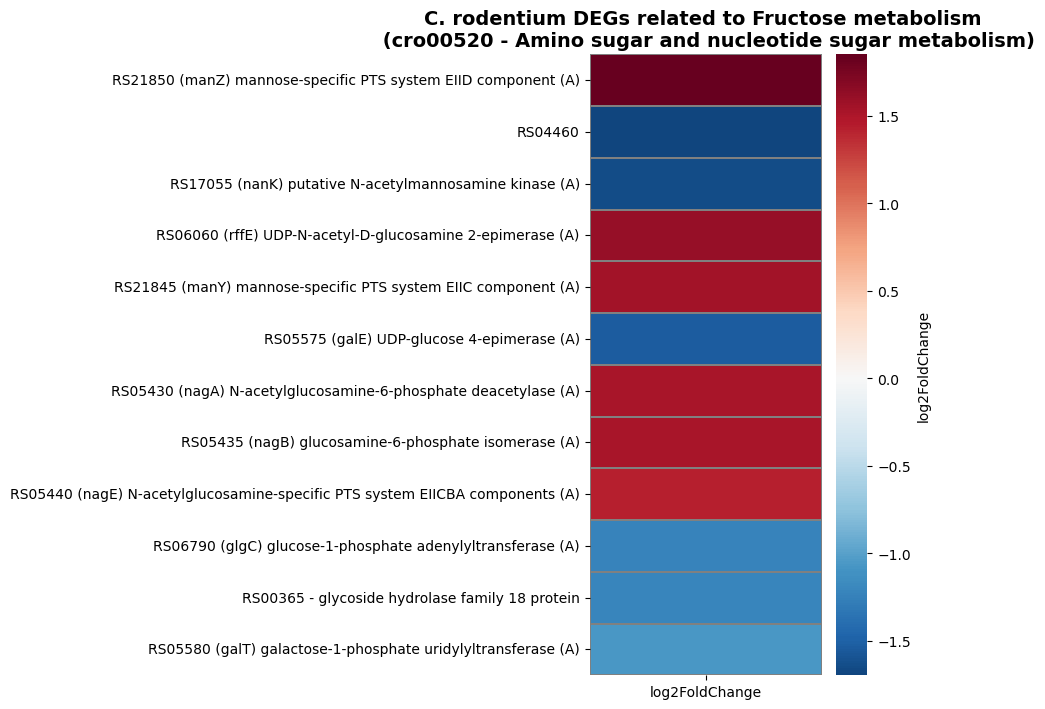

In [59]:
pg_degs_all, _, _ = AplicaTudo('cro00520', 'C. rodentium DEGs related to Fructose metabolism \n (cro00520 - Amino sugar and nucleotide sugar metabolism)')